In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
     |████████████████████████████████| 3.8MB 53.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import re
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import os
import unicodedata
import urllib3
import zipfile

In [5]:
import pandas as pd
news_df = pd.read_excel('/content/drive/My Drive/03_홍경수쌤_수업/B반/data/kor.xlsx', sheet_name='Sheet1')
train_df, val_df, test_df = news_df.iloc[:50000, 1:], news_df.iloc[50000:63000, 1:], news_df.iloc[63000:, 1:]

In [6]:
train_df.shape,val_df.shape, test_df.shape

((50000, 2), (13000, 2), (12000, 2))

## 전처리

유니코드(Unicode) 문자열은 문자를 Unicode로 취급하기 때문에 영어나 한국어등의 ASCII 문자로 되어있어도 한 개 문자를 하나씩 다룹니다.

즉, 일반 문자열은 바이트 단위로 처리 하지만, 유니코드 문자열에서는 문자 단위로 처리하게 됩니다.

한글을 글자 깨짐 없이 사용하고 싶은 경우에는 유니코드 문자열을 사용하면 됩니다.

In [7]:
def unicode_to_ascii(s): 
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [8]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    # sent = unicode_to_ascii()

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

In [9]:
# 전처리 테스트
# 문자열 앞에 [u]또는 [U]를 붙여주면 유니코드 문자열이 됩니다.

kor_sent1 = u"저녁 먹었어?"
eng_sent1 = u"Have you had dinner?"

print(preprocess_sentence(eng_sent1))
print(preprocess_sentence(kor_sent1))

Have you had dinner ?
저녁 먹었어 ?


- 전체 데이터에서 33,000개의 샘플만 불러오되, 모든 전처리를 수행하는 함수를 만듭니다.   
- 또한 훈련 과정에서 교사 강요(Teacher Forcing)을 사용할 예정이므로, 훈련 시 사용할 디코더의 입력 시퀀스와 실제값에 해당되는 출력 시퀀스를 따로 분리하여 저장합니다.   
- 입력 시퀀스에는 시작을 의미하는 토큰인 \<sos\>를 추가하고, 출력 시퀀스에는 종료를 의미하는 토큰인 \<eos\>를 추가합니다  

In [10]:
def load_preprocessed_data(df):
    encoder_input, decoder_input, decoder_target = [], [], []
    for i in range(len(df)):
      src_line = df.iloc[i][0].strip()
      tar_line = df.iloc[i][1].strip()

      # source 데이터 전처리
      src_line_input = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_input = [w for w in ("<sos> " + tar_line).split()]
      tar_line_target = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line_input)
      decoder_input.append(tar_line_input)
      decoder_target.append(tar_line_target)

      # if i == num_samples - 1:
      #     break

    return encoder_input, decoder_input, decoder_target

In [11]:
# encoder_input, decoder_input, decoder_target
sents_kor_in, sents_eng_in, sents_eng_out = load_preprocessed_data(train_df)
sents_kor_in_val, sents_eng_in_val, sents_eng_out_val = load_preprocessed_data(val_df)
sents_kor_in_test, sents_eng_in_test, sents_eng_out_test= load_preprocessed_data(test_df)

In [12]:
print(sents_kor_in[-5:])
print(sents_eng_in[-5:])
print(sents_eng_out[-5:])

[['일요일에도', '역시', '골프를', '할', '것이에요', '.'], ['가족', '들과', '여행', '하면서', '추억을', '쌓을', '것이에요', '.'], ['나는', '이번', '여름방학에', '계획을', '잘', '세워서', '재미있게', '보낼', '것이에요', '.'], ['나는', '스물', '여섯', '살에', '은행원으로', '취직을', '할', '것이에요', '.'], ['나는', '이번', '여름', '동안', '카리브해로', '여행', '갈', '것이에요', '.']]
[['<sos>', 'I', 'will', 'play', 'golf', 'on', 'Sunday', 'as', 'well', '.'], ['<sos>', 'I', 'will', 'make', 'memorable', 'moments', 'with', 'my', 'family', 'on', 'the', 'trip', '.'], ['<sos>', 'I', 'will', 'have', 'a', 'fun', 'summer', 'break', 'by', 'planning', 'well', '.'], ['<sos>', 'I', 'will', 'be', 'hired', 'as', 'a', 'banker', 'at', 'twenty', 'six', '.'], ['<sos>', 'I', 'will', 'travel', 'to', 'the', 'Caribbean', 'during', 'the', 'summer', '.']]
[['I', 'will', 'play', 'golf', 'on', 'Sunday', 'as', 'well', '.', '<eos>'], ['I', 'will', 'make', 'memorable', 'moments', 'with', 'my', 'family', 'on', 'the', 'trip', '.', '<eos>'], ['I', 'will', 'have', 'a', 'fun', 'summer', 'break', 'by', 'planning', 'well',

In [13]:
# 인코딩
tokenizer_kor = Tokenizer()
tokenizer_kor.fit_on_texts(sents_kor_in)
encoder_input_train = tokenizer_kor.texts_to_sequences(sents_kor_in)

tokenizer_eng = Tokenizer(filters="", lower=True)
tokenizer_eng.fit_on_texts(sents_eng_in)
tokenizer_eng.fit_on_texts(sents_eng_out)
decoder_input_train = tokenizer_eng.texts_to_sequences(sents_eng_in)
decoder_target_train = tokenizer_eng.texts_to_sequences(sents_eng_out)

In [14]:
encoder_input_val = tokenizer_kor.texts_to_sequences(sents_kor_in_val)
decoder_input_val = tokenizer_eng.texts_to_sequences(sents_eng_in_val)
decoder_target_val = tokenizer_eng.texts_to_sequences(sents_eng_out_val)

encoder_input_test = tokenizer_kor.texts_to_sequences(sents_kor_in_test)
decoder_input_test = tokenizer_eng.texts_to_sequences(sents_eng_in_test)
decoder_target_test = tokenizer_eng.texts_to_sequences(sents_eng_out_test)

In [15]:
# 패딩
encoder_input_train = pad_sequences(encoder_input_train, padding="post")
decoder_input_train = pad_sequences(decoder_input_train, padding="post")
decoder_target_train = pad_sequences(decoder_target_train, padding="post")

In [16]:
encoder_input_val = pad_sequences(encoder_input_test, padding="post")
decoder_input_val = pad_sequences(decoder_input_test, padding="post")
decoder_target_val = pad_sequences(decoder_target_test, padding="post")

encoder_input_test = pad_sequences(encoder_input_test, padding="post")
decoder_input_test = pad_sequences(decoder_input_test, padding="post")
decoder_target_test = pad_sequences(decoder_target_test, padding="post")

In [17]:
encoder_input_train.shape, encoder_input_test.shape, decoder_target_test.shape

((50000, 15), (12000, 13), (12000, 18))

In [18]:
src_vocab_size = len(tokenizer_kor.word_index) + 1
tar_vocab_size = len(tokenizer_eng.word_index) + 1
print("한국어 단어 집합의 크기 : {:d}, 영어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

한국어 단어 집합의 크기 : 62226, 영어 단어 집합의 크기 : 15496


In [19]:
src_to_index = tokenizer_kor.word_index
index_to_src = tokenizer_kor.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_eng.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_eng.index_word # 훈련 후 결과 비교할 때 사용

In [20]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_val.shape)
print(decoder_input_val.shape)
print(decoder_target_val.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(50000, 15)
(50000, 19)
(50000, 19)
(12000, 13)
(12000, 18)
(12000, 18)
(12000, 13)
(12000, 18)
(12000, 18)


In [21]:
encoder_input_train

array([[    4,   238,   333, ...,     0,     0,     0],
       [ 2021, 21226,  1072, ...,     0,     0,     0],
       [  967,  6518,   102, ...,     0,     0,     0],
       ...,
       [    4,   126, 62222, ...,     0,     0,     0],
       [    4, 62223,  2175, ...,     0,     0,     0],
       [    4,   126,   790, ...,     0,     0,     0]], dtype=int32)

## 기계 번역기 만들기

In [28]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [29]:
src_vocab_size

62226

In [30]:
latent_dim = 100

In [31]:
num_decoder_tokens = tar_vocab_size
num_encoder_tokens = src_vocab_size

In [32]:
# 인코더 Layer 2개 
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
e_outputs, h1, c1 = LSTM(latent_dim, return_state=True, return_sequences=True)(enc_masking)
encoder_lstm= LSTM(latent_dim, return_state=True, return_sequences=True)
_, h2, c2 = encoder_lstm(e_outputs) # 은닉 상태와 셀 상태를 리턴
encoder_states = [h1, c1, h2, c2] # 인코더의 은닉 상태와 셀 상태를 저장

# 디코더 Layer 2개 
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) 
dec_masking = Masking(mask_value=0.0)(dec_emb) # 패딩 0은 연산에서 제외

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
out_layer1 = LSTM(latent_dim, return_sequences=True, return_state=True)
d_outputs, dh1, dc1 = out_layer1(dec_masking,initial_state= [h1, c1]) # 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
out_layer2 = LSTM(latent_dim, return_sequences=True, return_state=True)
final, dh2, dc2 = out_layer2(d_outputs, initial_state= [h2, c2])
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(final)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    6222600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1549600     input_2[0][0]                    
_______________________________________________________________________________________

In [33]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics = ['acc'])

In [34]:
checkpoint_dir = '/content/drive/My Drive/Project/Seq To Seq/ckpt4'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3),   
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + '/ckpt2-loss={loss:.4f}'
      )
    ]
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val),
          batch_size = 128, epochs = 30, callbacks = callbacks)

Epoch 1/30
391/391 [==============================] - ETA: 0s - loss: 4.1878 - acc: 0.4117WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Project/Seq To Seq/ckpt4/ckpt2-loss=4.1878/assets
391/391 [==============================] - 88s 224ms/step - loss: 4.1878 - acc: 0.4117 - val_loss: 3.5176 - val_acc: 0.4578
Epoch 2/30
391/391 [==============================] - 84s 216ms/step - loss: 3.1880 - acc: 0.5315 - val_loss: 3.1714 - val_acc: 0.5280
Epoch 3/30
391/391 [==============================] - 85s 217ms/step -

## seq2seq 기계 번역기 동작시키기

In [35]:
# 인코더 모델
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 모델 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c, 
                         decoder_state_input_h1, decoder_state_input_c1]

# 임베딩 
dec_emb2= dec_emb_layer(decoder_inputs)

d_o, state_h, state_c = out_layer1(dec_emb2, initial_state=decoder_states_inputs[:2])
d_o, state_h1, state_c1 = out_layer2(d_o, initial_state=decoder_states_inputs[-2:])
decoder_states = [state_h, state_c, state_h1, state_c1]
decoder_outputs = decoder_dense(d_o)

In [36]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

decoder_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1549600     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
_______________________________________________________________________________________

In [37]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,4))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c, h1, c1 = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        try:
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_char = index_to_tar[sampled_token_index]
        except:
          sampled_token_index = np.argsort(output_tokens[0, -1, :])[::-1][1]
          sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c, h1, c1]

    return decoded_sentence

In [38]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

In [39]:
for seq_index in [3,5,100,30,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_train[seq_index]))
  print("번역문 :",seq2tar(decoder_input_train[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  나는 오늘 자정에 한국으로 돌아 가요 . 
번역문 : i m going back to korea today at midnight . 
예측문 :  i have to go . 


원문 :  지금 잠을 자면 깨어나지 못할 거 같아서 지금 가요 . 
번역문 : if i fall asleep i might not get up so i will go right now . 
예측문 :  i have to be busy so i will not do it . 


원문 :  어제 밤에 왔고 오늘 밤에 가요 . 
번역문 : i came yesterday and i will leave today . 
예측문 :  i have to go . 


원문 :  다음주 목요일 일에 한국으로 돌아 가요 . 
번역문 : i will be going back to korea next thursday . 
예측문 :  you are going to korea . 


원문 :  그러나 인보이스의 단가는 잘못된 것 같아 . 
번역문 : but i think the price of invoice is wrong . 
예측문 :  it is in the first . 




In [41]:
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction
def sentences_to_bleu(ref, pred):
  """
  ref : 참고용 타겟 문장(학습용 영어 문장)
  pred : 예측 문장(번역 결과)
  """
  smoothie = SmoothingFunction().method4
  return bleu.sentence_bleu(ref, pred, smoothing_function=smoothie)

In [54]:
from tqdm import tqdm_notebook
ref_list = []
pred_list = []
bleu_score = []

for seq_index in tqdm_notebook(range(0, 12000)):
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)[:-5]

  ref = [seq2tar(decoder_input_test[seq_index]).split()]
  pred = decode_sequence(input_seq)[:-5].split()

  ref_list.append(seq2tar(decoder_input_test[seq_index]))
  pred_list.append(decode_sequence(input_seq)[:-5]) 
  bleu_score.append(bleu.sentence_bleu(ref, pred))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


KeyboardInterrupt: ignored

In [43]:
df = pd.DataFrame([ref_list, pred_list, bleu_score])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6386,6387,6388,6389,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399,6400,6401,6402,6403,6404,6405,6406,6407,6408,6409,6410,6411,6412,6413,6414,6415,6416,6417,6418,6419,6420,6421,6422,6423,6424,6425
0,and i m here to explain the reason for this .,i want to say about the cosmetic today .,we would like to renew the contract in the con...,our summer vacation starts next week .,she is an interesting writer who creates new t...,it begins soon after the rainy season is over .,plus three tops i ordered don t fit me they re...,it will begin when the school me to the compan...,since tuna is in season now let s start with t...,begin to work not thinking of putting off it .,split the work in detail before you start .,and they gradually started to realize the trut...,then the brothers get into a conflict .,people guess your personality by blood type in...,i came to work and started doing today s work .,i arrived at the company and drank morning cof...,begin our travel phillippines trip .,he starts to chase the criminal with jeon .,something scary and weird starts to happen .,he begins to design a shoe just for her .,middle school students take midterm exams from...,the weather is warm and the flowers are starti...,restart game to language to korean .,i begin with the living guidance when i arrive...,going out is a pain for me recently .,i started the treatment because you were hurt ...,i ve started to in the room without people kno...,i will start studying chinese from tomorrow .,i start two stages of a diet from today .,normal life becomes enviable from some moment .,i connected to computer and it works here .,let s start putting together one thing at a ti...,many years pass and the aged stars become smal...,so let s start again starting next week .,we start the debate about the stupid .,we start reviewing as you officially submit it .,we start construction of expanding the of beac...,the pot that has a starts to boil .,is starting her swimming lessons starting tomo...,as a result the asians and the whites started ...,...,if you don t respond i won t talk to you .,i ll use your credit card to shopping tomorrow .,foreigners won t understand you if you speak l...,i m inviting your family for dinner .,after he sees my picture we ll start to talk a...,i m not good at english but i m going to try h...,i will miss you by the end of this year .,i will love you forever so that you will never...,i will travel after finishing this factory wor...,i will trust and like you just like my mind fo...,i will try to resolve this small problem .,i will run a small convenience store soon .,among other things we are going to introduce k...,you will decide the same as i did if you get h...,i am not going to do anything this week .,we re going to ask the store to do a broadcast .,i will never speak to you again if you contact...,i will choose the food looking the best delici...,if you come to korea again i will be happy for...,we ll use the address that we used before .,it will probably arrive before you move away .,i will not forget the few months i spent with ...,i won t act like i know you even i met you in ...,im not gonna watch movies with you anymore .,what are you going to do with the decorating i...,what would you do if you were in that situatio...,cheer up on korean study and i will hope for t...,i will study hard on speaking as i listen to t...,i will tell you when i install in the computer .,i m happy to be in touch with you .,i will invite all of you to my bakery .,i can t speak english well so will say slowly .,i will do my best to provide an awesome event .,we would put our best effort to quickly finish...,when i go to beijing i promise i ll visit you .,i ll write to you when i get to japan .,i ll try to be on time from now on .,i m looking forward to seeing you in japan som...,i ll tell paul that you have called .,rest i won t let 

In [44]:
df = df.transpose()
df.columns = ['ref', 'pred', 'bleu']
df

,ref,pred,bleu
0,and i m here to explain the reason for this .,do there s .,0.122877
1,i want to say about the cosmetic today .,i do not .,0.240921
2,we would like to renew the contract in the con...,do you have to be .,0.279528
3,our summer vacation starts next week .,we will do .,0.334014
4,she is an interesting writer who creates new t...,do you have been .,0.246016
...,...,...,...
6421,i ll write to you when i get to japan .,i have to be .,0.265085
6422,i ll try to be on time from now on .,do you have to work .,0.330223
6423,i m looking forward to seeing you in japan som...,i do there to .,0.217033
6424,i ll tell paul that you have called .,you are too .,0.240921


In [45]:
df.to_csv('./lstm_bleu.csv', index = False)

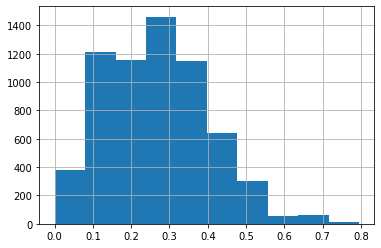

In [48]:
import matplotlib.pyplot as plt
df['bleu'].hist()

In [47]:
np.array(bleu_score).mean()

0.2702554044922252

In [49]:
from tqdm import tqdm_notebook
ref_list = []
pred_list = []
bleu_score = []

for seq_index in tqdm_notebook(range(0, 10)):
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)[:-5]

  ref = [seq2tar(decoder_input_test[seq_index]).split()]
  pred = decode_sequence(input_seq)[:-5].split()
  print(ref)
  print(pred)
  ref_list.append(seq2tar(decoder_input_test[seq_index]))
  pred_list.append(decode_sequence(input_seq)[:-5]) 
  bleu_score.append(bleu.sentence_bleu(ref, pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[['and', 'i', 'm', 'here', 'to', 'explain', 'the', 'reason', 'for', 'this', '.']]
['do', 'there', 's', '.']


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


[['i', 'want', 'to', 'say', 'about', 'the', 'cosmetic', 'today', '.']]
['i', 'do', 'not', '.']
[['we', 'would', 'like', 'to', 'renew', 'the', 'contract', 'in', 'the', 'condition', 'above', '.']]
['do', 'you', 'have', 'to', 'be', '.']
[['our', 'summer', 'vacation', 'starts', 'next', 'week', '.']]
['we', 'will', 'do', '.']
[['she', 'is', 'an', 'interesting', 'writer', 'who', 'creates', 'new', 'things', '.']]
['do', 'you', 'have', 'been', '.']
[['it', 'begins', 'soon', 'after', 'the', 'rainy', 'season', 'is', 'over', '.']]
['the', 'is', 'is', 'important', '.']
[['plus', 'three', 'tops', 'i', 'ordered', 'don', 't', 'fit', 'me', 'they', 're', 'small', '.']]
['i', 'have', 'to', 'be', '.']
[['it', 'will', 'begin', 'when', 'the', 'school', 'me', 'to', 'the', 'company', '.']]
['i', 'have', 'to', 'be', '.']
[['since', 'tuna', 'is', 'in', 'season', 'now', 'let', 's', 'start', 'with', 'that', '.']]
['i', 'do', 'there', '.']
[['begin', 'to', 'work', 'not', 'thinking', 'of', 'putting', 'off', 'it', 

In [53]:
bleu.sentence_bleu([['i', 'want', 'to', 'say', 'about', 'the', 'cosmetic', 'today', '.']], ['i', 'do', 'not', '.'])

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.24092085663272753